# Machine Learning - Assignment 1

- **Group B**:
 - Ana Raquel Maceiras (up200604342) 
 - Hélder Vieira (up201503395)
 - Miguel Tavares (up200902937)
 - Rui Vieira (up201403035)         

## Introdução

No mundo actual existem cada vez mais dados disponíveis sobre o dia a dia de um cidadão normal, quer seja através da utilização dos mais diversos dispositivos como através da utilização de serviços colectivos em grandes centros urbanos. De forma a ser possível prever comportamentos ou tendências da população em geral, a procura por modelos de aprendizagem tem aumentado. Grandes parte destes modelos baseiam-se na classificação de determinada(s) categoria(s). Contudo, em situações reais, a linha real de separação entre as diferentes categorias alvo não é conhecida restando a tentativa de obtenção de uma linha o mais próxima possível desta. Assim, estes modelos oferecem-nos potenciais regiões de classificação com uma determinada confiança.<br>
Existem diversos métodos, muitos de aplicação directa, outros exigem o aperfeiçoamento de hiperparâmetros. Todo este processo implica um estudo prévio e posterior tratamentos dos dados, os quais servirão como base de treino do modelo. Cada modelo terá uma expressividade única, que poderá incorrer em *overfitting* ou *underfitting*, fortemente relacionado com a razão entre bias/variance.<br>
Neste trabalho procuramos analisar o comportamento de diversos métodos de *machine learning* para dois casos distintos de dados e de observar o impacto do aprefeiçoamento dos hiperparâmetros na performance dos mesmos.<br>
Na primeira parte iremos observar que alguns modelos, mesmo sendo pouco flexíveis podem oferecer uma boa resposta para situações específicas, e onde também os modelos mais flexíveis convergem para complexidades similares, obtendo-se fronteiras de decisão semelhantes. Na segunda e última parte deste trabalho observaremos que, conjuntos de dados com classes pouco representadas irão dar lugar a modelos que não as consideram sem que para isso, seja investido um grande esforço no aperfeiçoamento.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from matplotlib import colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, validation_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DTreeClass
from sklearn.metrics import accuracy_score, zero_one_loss, roc_auc_score, roc_curve, classification_report, f1_score
from scipy import stats

In [2]:
names = ['Sequence name','mcg','gvh','alm','mit','erl','pox','vac','nuc','class'];
data_yeast = pd.read_csv('yeast.data', header = None, sep = '\s+', names = names);
data_pima = pd.read_csv('diabetes.csv');

## Questão 1

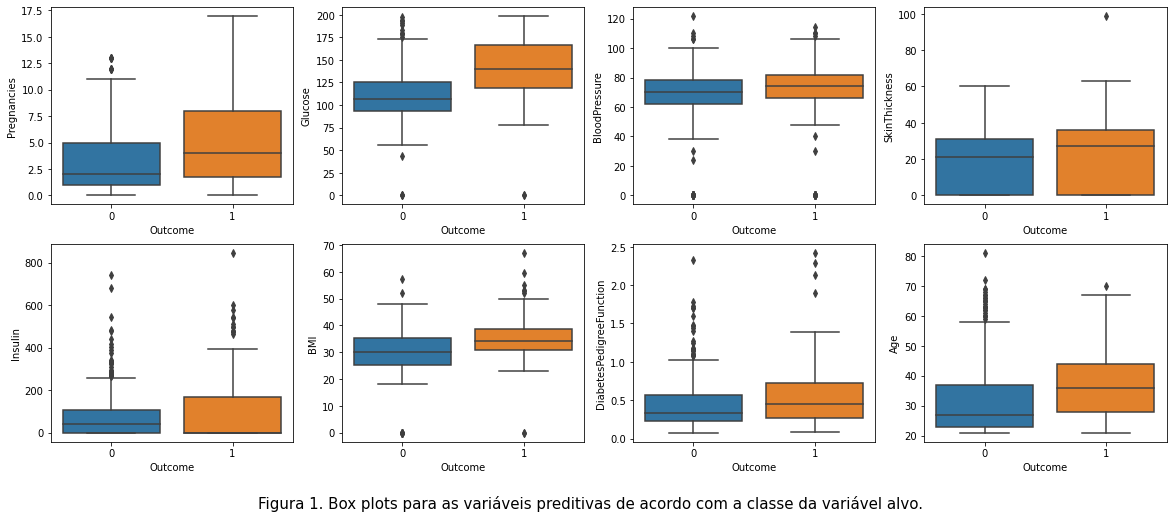

In [3]:
cols = data_pima.columns[:8]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(20, 8))
txt="Figura 1. Box plots para as variáveis preditivas de acordo com a classe da variável alvo."
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='Outcome', data=data_pima)
    ax[i//4, i%4].set(xlabel='Outcome')
plt.show();

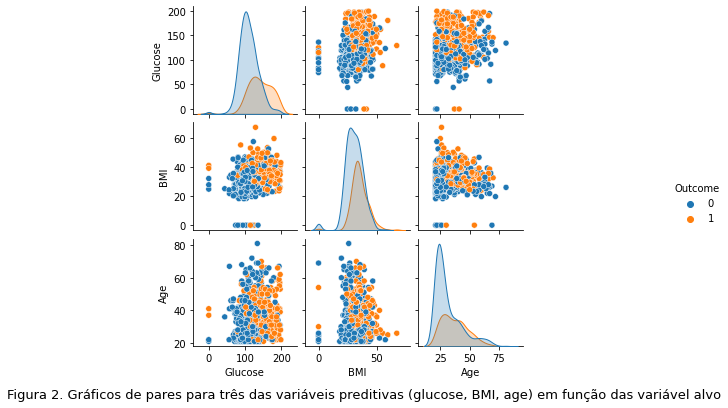

In [4]:
data_pima_sel = data_pima.drop(columns = ['BloodPressure', 'SkinThickness', 'Pregnancies', 'DiabetesPedigreeFunction', 'Insulin'])
sns.pairplot(data_pima_sel, hue = 'Outcome', size=1.8)
txt="Figura 2. Gráficos de pares para três das variáveis preditivas (glucose, BMI, age) em função das variável alvo"
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=13)
plt.show();

Após análise aos gráficos apresentados, podemos observar rapidamente que as variáveis que melhor "separam" a variável alvo são *Glucose*, *BMI* e *Age*. Contudo, as duas escolhidas (como requisitado pelo exercicio) foram a *Glucose* e *BMI*. A variável *Age* foi descartada pois tinha mais outliers.

## Comparação dos modelos: kNN, Logistic Regression, QDA

Após a escolha das duas variáveis preditivas, foram removidos alguns dados pois os mesmos representavam situação não reais (p.e. valores de glucose nulos). Para além disso, uma vez que um dos modelos depende do cálculo de distâncias (kNN), procedeu-se à normalização dos valores para as variáveis *Glucose* e *BMI*.

In [5]:
data_pima_clean = data_pima_sel[(data_pima_sel['Glucose'] != 0) & (data_pima_sel['BMI'] != 0)]
data_pima_clean = data_pima_clean.sample(frac=1).reset_index(drop=True)
data_pima_sel_final = data_pima_clean.drop(columns = 'Age')

#### Separação dos dados para treino e teste e normalização dos dados

In [6]:
X = data_pima_sel_final.drop(columns = 'Outcome').values
y = data_pima_sel_final.loc[:,'Outcome'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify= y)

minmax_scaler = MinMaxScaler()
x_train = minmax_scaler.fit_transform(x_train)
x_test = minmax_scaler.transform(x_test)

In [7]:
def plot_classifier_boundary(model,x,h = .05): #kindly provided in class
    cmap_light = colors.ListedColormap(['lightsteelblue', 'peachpuff'])
    x_min, x_max = x[:, 0].min()-.2, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.2, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cmap_light)
    plt.xlim((x_min,x_max))
    plt.ylim((y_min,y_max))
cmap = colors.ListedColormap(['blue','orange'])

In [8]:
def StratKF(model, splits, x_train, y_train, x_test, y_test): #fitted model necessary
    SKF = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1)
    f_score = []
    ac_score = []
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    for train_index, test_index in SKF.split(x_test, y_test):
        x_test1 = x_train[test_index]
        y_test1 = y_train[test_index]
        f_score.append(f1_score(y_test1, model.predict(x_test1)))
        ac_score.append(accuracy_score(y_test1, model.predict(x_test1)))
    print('Accuracy score on training set: ',round(accuracy_score(y_train, y_pred_train),4), '\nAccuracy score on test set: ',round(accuracy_score(y_test, y_pred_test), 4))
    print('Accuracy score on {}-fold test data: '.format(splits),round(np.mean(ac_score),4),'+/-', round(np.std(ac_score),4))
    print('F1 score on training set: ',round(f1_score(y_train, y_pred_train),4), '\nF1 score on test set: ',round(f1_score(y_test, y_pred_test), 4))
    print('F1 score on {}-fold test data: '.format(splits),round(np.mean(f_score),4),'+/-', round(np.std(f_score),4))

### Logistic Regression

In [9]:
modelLogReg = LogReg()
modelLogReg.fit(x_train, y_train)
StratKF(modelLogReg,5, x_train, y_train, x_test, y_test)

Accuracy score on training set:  0.7587 
Accuracy score on test set:  0.7483
Accuracy score on 5-fold test data:  0.8015 +/- 0.0282
F1 score on training set:  0.5892 
F1 score on test set:  0.5581
F1 score on 5-fold test data:  0.6339 +/- 0.1365


### Quadratic Discriminant Analysis

In [10]:
modelQDA = QDA()
modelQDA.fit(x_train, y_train)
StratKF(modelQDA,5, x_train, y_train, x_test, y_test)

Accuracy score on training set:  0.7654 
Accuracy score on test set:  0.755
Accuracy score on 5-fold test data:  0.7951 +/- 0.0363
F1 score on training set:  0.6137 
F1 score on test set:  0.5843
F1 score on 5-fold test data:  0.6278 +/- 0.1356


### k Nearest Neighbors

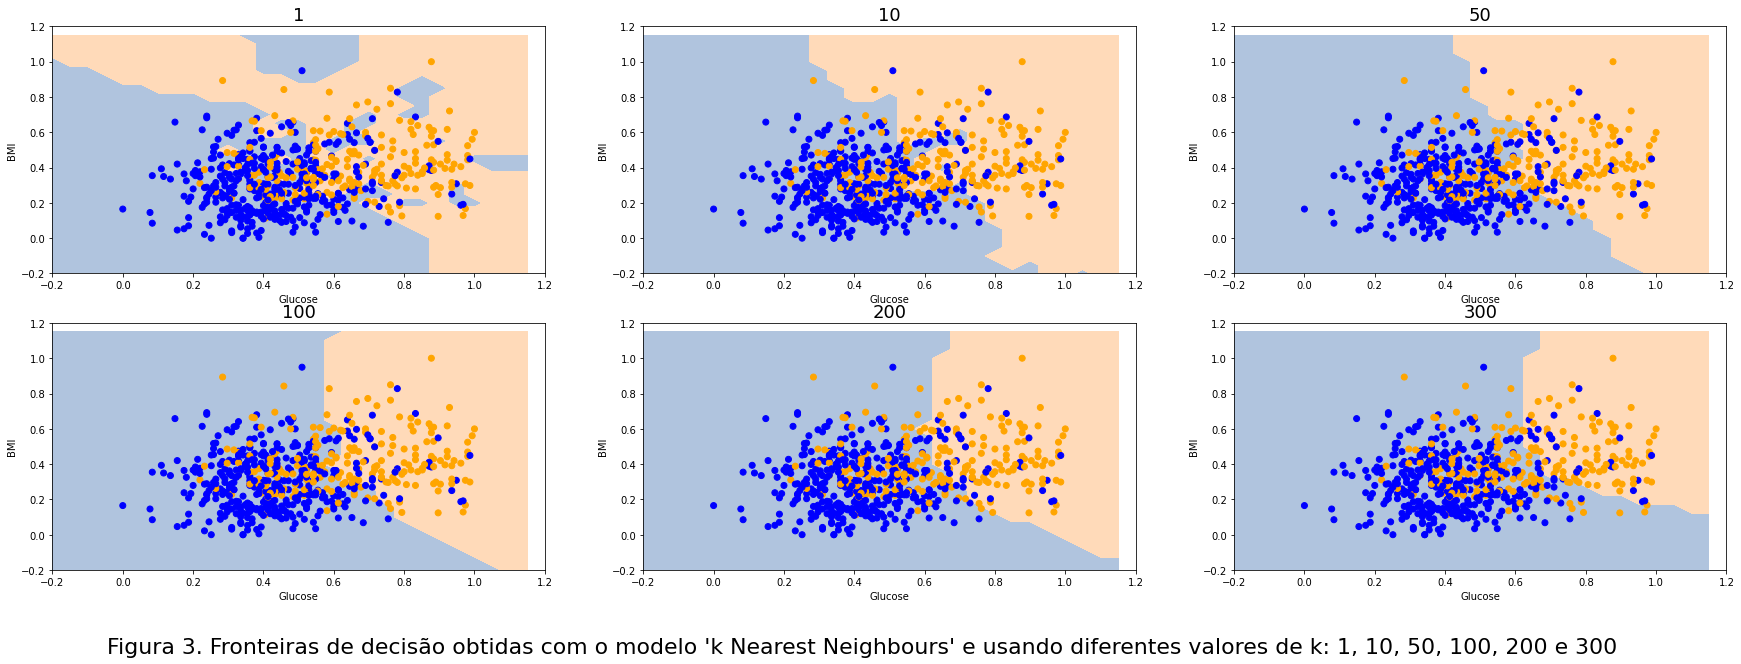

In [11]:
fig = plt.figure(figsize=(30,10))
k = [1,10,50,100,200,300]
for i in range(len(k)):
    modelkNN = kNN(n_neighbors=k[i])
    modelkNN.fit(x_train, y_train)
    ax = fig.add_subplot(2, 3, i+1)
    plot_classifier_boundary(modelkNN, x_train)
    ax.scatter(x_train[:,0],x_train[:,1],color=cmap(y_train))
    ax.set_title(k[i], fontsize = 18)
    ax.set_xlabel('Glucose')
    ax.set_ylabel('BMI')
txt="Figura 3. Fronteiras de decisão obtidas com o modelo 'k Nearest Neighbours' e usando diferentes valores de k: 1, 10, 50, 100, 200 e 300"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=22)
plt.show;

Como esperado, e anteriormente referenciado, à medida que o número de *nearest neighbors* (k) aumenta, a complexidade do modelo diminui. Observando a figura 3 podemos concluir que a fronteira de decisão vai se tornando mais simples.

In [12]:
def valid_curve(model, x_train, y_train, n_jobs, scoring, param_range = np.array([*range(1,301)]), param_name="n_neighbors"):
    np.random.seed(1)
    train_scores, test_scores = validation_curve(model, x_train, y_train, param_name=param_name, param_range=param_range, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(6, 3))
    plt.title("kNN Validation Curve")
    plt.xlabel("k Neighbors")
    plt.ylabel("Score")
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="navy")
    plt.legend(loc="best")
    print("Best K is %d" %param_range[np.where(test_scores_mean == max(test_scores_mean))][0])
    return param_range[np.where(test_scores_mean == max(test_scores_mean))][0]

Best K is 71


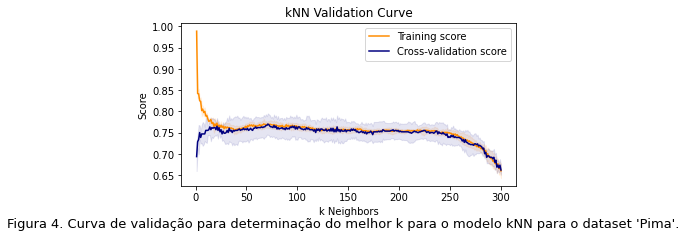

In [13]:
modelkNN = kNN()
k_best = valid_curve(modelkNN, x_train, y_train, 6, 'accuracy')
txt="Figura 4. Curva de validação para determinação do melhor k para o modelo kNN para o dataset 'Pima'."
plt.figtext(0.5, -0.07, txt, wrap=True, horizontalalignment='center', fontsize=13)
plt.show();

Como se pode visualizar na figura da fronteira de classificação e na curva de validação, inicialmente (aprox. até k igual 5) ocorre *overfitting*, seguidamente com o aumento do k existe uma tendência de estabilização da fronteira sendo que os scores de treino e CV são similares até um k de aproximadamente 250 em que começa a ocorrer *underfitting*. O k escolhido como ideal corresponde ao maximizante do score da CV.

In [14]:
modelkNN = kNN(n_neighbors=k_best)
modelkNN.fit(x_train, y_train)
StratKF(modelkNN,5, x_train, y_train, x_test, y_test)

Accuracy score on training set:  0.7671 
Accuracy score on test set:  0.7285
Accuracy score on 5-fold test data:  0.788 +/- 0.0274
F1 score on training set:  0.6154 
F1 score on test set:  0.5287
F1 score on 5-fold test data:  0.6111 +/- 0.1113


In [15]:
#ROC AUC
ns_probs = [0 for _ in range(len(y_test))]
# probabilities for the positive outcome
LogReg_probs = modelLogReg.predict_proba(x_test)[:, 1]
QDA_probs = modelQDA.predict_proba(x_test)[:, 1]
kNN_probs = modelkNN.predict_proba(x_test)[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
LogReg_auc = roc_auc_score(y_test, LogReg_probs)
QDA_auc = roc_auc_score(y_test, QDA_probs)
kNN_auc = roc_auc_score(y_test, kNN_probs)
# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('LR ROC AUC=%.3f' % (LogReg_auc))
print('QDA ROC AUC=%.3f' % (QDA_auc))
print('kNN ROC AUC=%.3f' % (kNN_auc))

LR ROC AUC=0.817
QDA ROC AUC=0.814
kNN ROC AUC=0.810


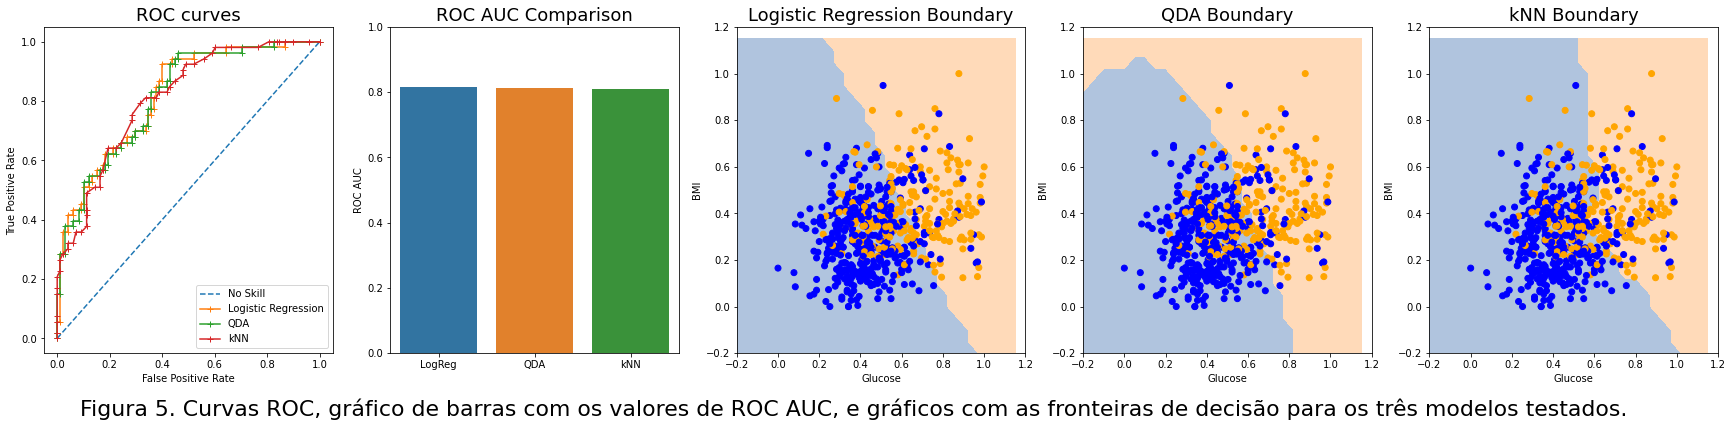

In [16]:
#ROC curves
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs, pos_label=None)
LogReg_fpr, LogReg_tpr, _ = roc_curve(y_test, LogReg_probs)
QDA_fpr, QDA_tpr, _ = roc_curve(y_test, QDA_probs)
kNN_fpr, kNN_tpr, _ = roc_curve(y_test, kNN_probs)
figs = plt.figure(figsize=(30,6))
# plot the roc curves
axs = figs.add_subplot(1, 5, 1)
axs.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs.plot(LogReg_fpr,LogReg_tpr, marker='+', label='Logistic Regression')
axs.plot(QDA_fpr,QDA_tpr, marker='+', label='QDA')
axs.plot(kNN_fpr,kNN_tpr, marker='+', label='kNN')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('ROC curves', fontsize = 18)
axs.legend();
##Barplot of AUCs
axs = figs.add_subplot(1, 5, 2)
sns.barplot(y=[LogReg_auc,QDA_auc,kNN_auc], x=['LogReg', 'QDA', 'kNN'], ax=axs)
axs.set_ylim(0,1)
axs.set_title('ROC AUC Comparison', fontsize = 18)
axs.set_ylabel('ROC AUC');
model_list = [(modelLogReg,'Logistic Regression Boundary') , (modelQDA, 'QDA Boundary'), (modelkNN, 'kNN Boundary')]
for i in range(3,6,1):
    axs = figs.add_subplot(1, 5, i)
    plot_classifier_boundary(model_list[i-3][0],x_train)
    axs.scatter(x_train[:,0],x_train[:,1],color=cmap(y_train))
    axs.set_xlabel('Glucose')
    axs.set_ylabel('BMI');
    axs.set_title(model_list[i-3][1], fontsize = 18)
txt="Figura 5. Curvas ROC, gráfico de barras com os valores de ROC AUC, e gráficos com as fronteiras de decisão para os três modelos testados."
plt.figtext(0.5, -0.02, txt, wrap=True, horizontalalignment='center', fontsize=22)
plt.show();

Nesta análise comparámos os três modelos directamente (o kNN foi alvo de ajuste de hiperparâmetros, recorrendo à análise do gráfico acima representado). Podemos observar que ambos os modelos obtêm um valor de AUC semelhante, a rondar os 75%.<br>
Observando as "linhas de fronteira" obtidas rapidamente podemos observar a semelhança entre a regressão logistica e o kNN, o que seria de esperar dado o valor elevado do k, bem como o valor quase idêntico do AUC. É importante também referir, que dado o *dataset* escolhido o qual contêm uma boa separação das classes, um modelo como a regressão logistica (pouco flexível), consegue apresentar um resultado quase idêntico ao modelo utilizado mais flexível, o kNN. Isto é consequência de o valor óptimo de k ser bastante elevado, o que leva a uma fronteira de decisão bastante linear. 
Relativamente à QDA, a fronteira obtida não se assemelha a uma linearização, mas sim a uma quadratização da linha. Não é um modelo tão flexível como o kNN, mas em alguns casos é possível que tenha um melhor comportamento devido à abordagem quadrática.

## Questão 2

#### Separação dos dados para treino e teste e normalização dos dados

In [17]:
X = data_yeast.loc[:, ['mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc']].values
Y = data_yeast.loc[:,'class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y, shuffle=True)

minmax_scaler = MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [18]:
def StratKFW(model, splits, X_train, Y_train, X_test, Y_test):
    Y_pred_trainLogReg = model.predict(X_train)
    Y_pred_testLogReg = model.predict(X_test)
    print('Weighted F1 score on training set: ',round(f1_score(Y_train, Y_pred_trainLogReg, average='weighted'),4), 
        '\nWeighted F1 score on test set: ',round(f1_score(Y_test, Y_pred_testLogReg, average='weighted'), 4))
    f1score = []
    accscore = []
    for train_index, test_index in SKF.split (X_test, Y_test):
        X_test1 = X_test[test_index]
        Y_test1 = Y_test[test_index]
        f1score.append(f1_score(Y_test1, model.predict(X_test1), average='weighted'))
        accscore.append(accuracy_score(Y_test1, model.predict(X_test1)))
    print(f'Weighted F1 score on {splits}-fold test data: ',round(np.mean(f1score),4),'+/-', round(np.std(f1score),4))
    print('\nClassification report:\n',classification_report(Y_test, Y_pred_testLogReg, digits=3))
    return f1score, accscore

### Logistic regression

In [19]:
modelLR = LogReg()
modelLR.fit(X_train, Y_train)
f1score_LogReg, accscore_LogReg = [], []
f1score_LogReg, accscore_LogReg = StratKFW(modelLR, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.5564 
Weighted F1 score on test set:  0.5435
Weighted F1 score on 5-fold test data:  0.5409 +/- 0.027

Classification report:
               precision    recall  f1-score   support

         CYT      0.507     0.753     0.606        93
         ERL      0.000     0.000     0.000         1
         EXC      0.000     0.000     0.000         7
         ME1      0.455     0.556     0.500         9
         ME2      0.000     0.000     0.000        10
         ME3      0.667     0.688     0.677        32
         MIT      0.617     0.592     0.604        49
         NUC      0.641     0.477     0.547        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.569       297
   macro avg      0.355     0.356     0.351       297
weighted avg      0.541     0.569     0.544       297



### k Nearest Neighbors

Best K is 17


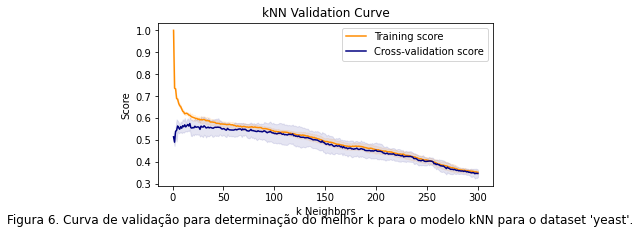

In [20]:
k_best = valid_curve(modelkNN, X_train, Y_train, 6, 'f1_weighted')
txt="Figura 6. Curva de validação para determinação do melhor k para o modelo kNN para o dataset 'yeast'."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show();

In [21]:
modelknn = kNN(n_neighbors=k_best)
modelknn.fit(X_train, Y_train)
f1score_knn, accscore_knn = [], []
f1score_knn, accscore_knn = StratKFW(modelknn, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.6207 
Weighted F1 score on test set:  0.5693
Weighted F1 score on 5-fold test data:  0.5664 +/- 0.0411

Classification report:
               precision    recall  f1-score   support

         CYT      0.530     0.656     0.587        93
         ERL      0.000     0.000     0.000         1
         EXC      0.667     0.571     0.615         7
         ME1      0.462     0.667     0.545         9
         ME2      0.333     0.200     0.250        10
         ME3      0.719     0.719     0.719        32
         MIT      0.681     0.653     0.667        49
         NUC      0.560     0.488     0.522        86
         POX      0.667     0.500     0.571         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.579       297
   macro avg      0.462     0.445     0.448       297
weighted avg      0.568     0.579     0.569       297



### Decision tree

In [22]:
modeltree = DTreeClass()
modeltree.fit(X_train, Y_train);

In [23]:
def model_grid_search(model, param_grid, cv, scoring, n_jobs): # "cv - integer, to specify the number of folds in a `(Stratified) KFold`,"
    model_grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = cv, refit = True, scoring= scoring, n_jobs = n_jobs)
    model_grid.fit(X_train, Y_train)
    print(f"Best estimator: {model_grid.best_estimator_} \n  Best score: {model_grid.best_score_} \n Best Params: {model_grid.best_params_}")
    return model_grid.best_estimator_

In [24]:
max_depth = [None] + [x for x in np.arange(1,20,4)]
min_sample_split= np.arange(2, 10,2)
min_sample_leaf = np.arange(1,5)
ccp_alpha = np.arange(0.01,100, 10)
param_grid_tree = {"criterion": ['gini', "entropy"],\
              "splitter": ['best',"random"],\
              "max_depth": max_depth,\
              "min_samples_split": min_sample_split,\
              "min_samples_leaf": min_sample_leaf, \
              "ccp_alpha": ccp_alpha}

In [25]:
tree_grid = model_grid_search(modeltree, param_grid_tree, 5, "f1_weighted", 2) 

Best estimator: DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       min_samples_leaf=4) 
  Best score: 0.5669393207369835 
 Best Params: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}


In [26]:
modeltree = tree_grid
f1score_tree, accscore_tree = StratKFW(modeltree, 5, X_train, Y_train, X_test, Y_test)

Weighted F1 score on training set:  0.5986 
Weighted F1 score on test set:  0.5512
Weighted F1 score on 5-fold test data:  0.5519 +/- 0.0611

Classification report:
               precision    recall  f1-score   support

         CYT      0.526     0.538     0.532        93
         ERL      0.000     0.000     0.000         1
         EXC      0.571     0.571     0.571         7
         ME1      0.571     0.889     0.696         9
         ME2      0.500     0.300     0.375        10
         ME3      0.711     0.844     0.771        32
         MIT      0.617     0.592     0.604        49
         NUC      0.522     0.547     0.534        86
         POX      0.000     0.000     0.000         4
         VAC      0.000     0.000     0.000         6

    accuracy                          0.566       297
   macro avg      0.402     0.428     0.408       297
weighted avg      0.542     0.566     0.551       297



### Comparação dos resultados obtidos para os diferentes modelos

In [27]:
stats_f1, pvalue_f1 = stats.f_oneway(f1score_LogReg, f1score_knn, f1score_tree)
print('p-value =',round(pvalue_f1,3), ': Não há diferenças estatísticas significativas entre as médias de "weighted F1-score" para os três modelos.')
stats_acc, pvalue_acc = stats.f_oneway(accscore_LogReg, accscore_knn, accscore_tree)
print('p-value =',round(pvalue_acc,3), ': Não há diferenças estatísticas significativas entre as médias de "accuracy" para os três modelos.')


p-value = 0.733 : Não há diferenças estatísticas significativas entre as médias de "weighted F1-score" para os três modelos.
p-value = 0.916 : Não há diferenças estatísticas significativas entre as médias de "accuracy" para os três modelos.


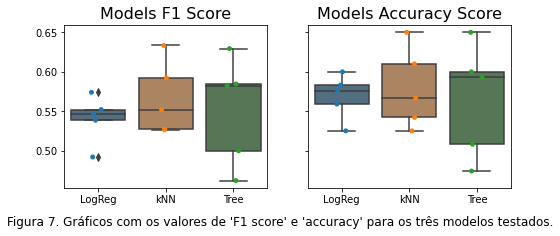

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)
#sns.set_theme(style="whitegrid")
ax[0].set_title('Models F1 Score', fontsize = 16)
ax[1].set_title('Models Accuracy Score', fontsize = 16)
sns.stripplot(y=f1score_LogReg + f1score_knn + f1score_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[0])
sns.boxplot(y=f1score_LogReg + f1score_knn + f1score_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, saturation=0.3, ax=ax[0])
sns.stripplot(y=accscore_LogReg + accscore_knn + accscore_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, ax=ax[1])
sns.boxplot(y=accscore_LogReg + accscore_knn + accscore_tree, x=['LogReg']*5+['kNN']*5+['Tree']*5, saturation=0.3, ax=ax[1]);
txt="Figura 7. Gráficos com os valores de 'F1 score' e 'accuracy' para os três modelos testados."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.show();

Nesta questão foi nos proposto comparar como 3 modelos se comportavam com um *dataset* com várias classes alvo com uma representatividade reduzida (*small classes*). Um dos maiores problemas devido ao problema anteriormente referido foi os modelos não serem capazes de detectar algumas dessas classes.
No modelo kNN foi realizada uma optimização do valor de k, e nas árvores de decisão, um *grid search*. No entanto, nenhum dos modelos conseguiu destacar-se dos restantes, obtendo-se resultados similares. 

## Conclusão

Dos resultados apresentados é possível concluir que os diversos modelos utilizados têm comportamentos distintos. No entanto, mesmo alguns sendo alvo de optimizações, verifica-se que a sua performance está muito dependente dos dados fornecidos.
Podiam ter sido abordados outros modelos de diferentes características e respectivas suposições mais adequados aos dados fornecidos, tais como o *random forest* que tira partido do *bagging*, o qual provavelmente detectaria também as classes menos representadas. Para além disso, métodos de *sampling*, que permitem balancear as classes presentes durante o treino iriam permitir um melhor treino dos modelos e, consequentemente, melhorar a performance destes; é o caso de *oversampling*, que permitiria uma melhor representatividade de todas classes através da duplicação das classes minoritárias.

## Referências

- Towards Data Science website (https://towardsdatascience.com/) <br>
- Hastie, T., Hastie, T., Tibshirani, R., & Friedman, J. H. (2001). The elements of statistical learning: Data mining, inference, and prediction. New York: Springer.<br>
- Bishop, C. M. (2006). Pattern recognition and machine learning. <br>

